In [2]:
import numpy as np
import pandas as pd
import ta
import scipy.stats
from datetime import datetime
import math
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import yfinance as yf

In [3]:
from sklearn.mixture import GaussianMixture

In [4]:
def preprocessing_yf(symbol,period=None,interval=None):
    global df
 #Import data
    print(period,interval)
    if period:
        if interval:
            df = yf.download(symbol,period=period,interval=interval).dropna()
        else:
            df = yf.download(symbol,period=period).dropna()
    else:
        if interval:
            df = yf.download(symbol,interval=interval).dropna()
        else:
            df = yf.download(symbol).dropna()

 #Rename
    df.columns = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]
    df.index.name = "Date"

    #Remove adj close
    # del df["adj close"]

    return df

In [5]:
df = preprocessing_yf("AAPL",None,None)
df = df.rename_axis('Date').reset_index()
df.head()

None None


[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099192,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094017,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087117,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089273,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091861,73449600


In [6]:
df = ta.add_all_ta_features(
    df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
df['date'] = df['Date'].apply(lambda x: datetime.strptime(str(x)[0:13],"%Y-%m-%d %H"))

# Slow : 60+
# Fast : 15

df.columns[25:]

Index(['volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp',
       'volatility_atr', 'volatility_ui', 'trend_macd', 'trend_macd_signal',
       'trend_macd_diff', 'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast',
       'trend_ema_slow', 'trend_vortex_ind_pos', 'trend_vortex_ind_neg',
       'trend_vortex_ind_diff', 'trend_trix', 'trend_mass_index', 'trend_dpo',
       'trend_kst', 'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
       'trend_stc', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_cci',
       'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
       'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up',
       'trend_psar_down', 'trend_psar_up_indicator',
       'trend_psar_down_indicator', 'momentum_r

In [7]:
# Feature Vector Calculations.
df['priceChange'] = df['Close']-df['Open']
df['priceChange_p'] = (df['Close']-df['Open'])/df['Open']

class_threshold = 0.01
df['classPriceChange'] = 1*(df['priceChange']>class_threshold)

df['dateInt'] = df['date'].apply(lambda x: (x - datetime(1970,1,1)).days)
df['close_r20'] = df.Close.rolling(20).mean()
df['close_r200'] = df.Close.rolling(200).mean()
df['APO_momentum'] = df['close_r20']-df['close_r200']
df['BOP'] = ((df['Close']-df['Open'])/(df['High']-df['Low'])).rolling(14).mean()
#df['CMO'] = chande_momentum_oscillator(df['Close'],period=20)
df['Momentum_10'] = df["Close"]-df["Close"].shift(10)

# Fast SMA is 12 days
# Slow EMA is 26 days

df['medPrice'] = ((df['High']+df['Low'])/2)
df['typPrice'] = ((df['High']+df['Low']+df['Close'])/3)
df['wtyPrice'] = ((df['High']+df['Low']+2*df['Close'])/3)

C:\Users\mlilje01\AppData\Local\Temp\ipykernel_13372\1153537533.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['typPrice'] = ((df['High']+df['Low']+df['Close'])/3)
C:\Users\mlilje01\AppData\Local\Temp\ipykernel_13372\1153537533.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['wtyPrice'] = ((df['High']+df['Low']+2*df['Close'])/3)


<Axes: title={'center': 'Daily AAPL Closing Prices in 2023 (1-Day Period)'}, xlabel='Date', ylabel='Closing Price'>

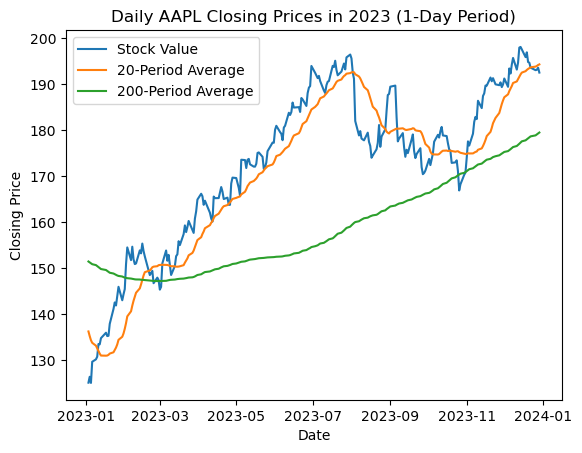

In [8]:
#sns.scatterplot(data=df_subset,x="date",y="Close",hue="classPriceChange")
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Day Mode
df_subset = df[(df['date']>np.datetime64('2022-12-31'))&(df['date']<np.datetime64('2024-01-01'))].reset_index(drop=True)

ax = sns.lineplot(data=df_subset,x="date",y="Close",label="Stock Value")
ax.set_title("Daily AAPL Closing Prices in 2023 (1-Day Period)")
plt.xlabel("Date")
plt.ylabel("Closing Price")

sns.lineplot(data=df_subset,x="date",y="close_r20",label="20-Period Average")
sns.lineplot(data=df_subset,x="date",y="close_r200",label="200-Period Average")

Text(0, 0.5, 'Closing Price')

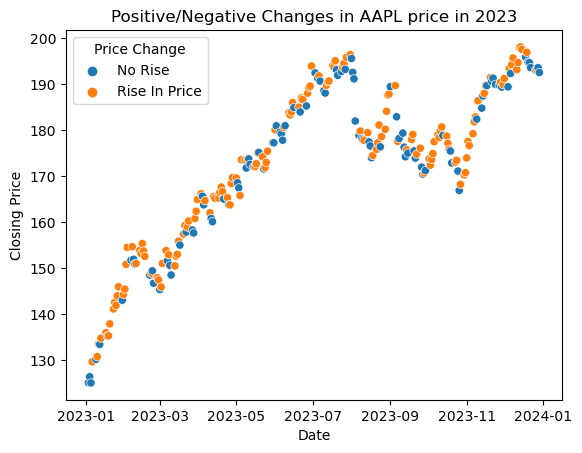

In [9]:
df_subset = df[(df['date']>np.datetime64('2022-12-31'))&(df['date']<np.datetime64('2024-01-01'))].reset_index(drop=True)

df_subset['Price Change'] = ["Rise In Price" if x==1 else "No Rise" for x in df_subset["classPriceChange"]]
ax = sns.scatterplot(data=df_subset,x="date",y="Close",hue='Price Change')
ax.set_title("Positive/Negative Changes in AAPL price in 2023")
plt.xlabel("Date")
plt.ylabel("Closing Price")

In [10]:
# known_vars
cols_dont_shift = ['classPriceChange','priceChange','priceChange_p','date','Date','dateInt']
cols_shift = [x for x in df.columns if x not in cols_dont_shift]
df2 = pd.concat(
    [
        df[['classPriceChange','priceChange','date','Date','dateInt']],
        df[list(df.columns[7:93])].shift(1),
        #df[['priceChange_p']].shift(1),
        df[list(df.columns[-9:])].shift(1),
    ],
    axis=1).dropna()

df2.head()
print(df2.iloc[:,1:5])

       priceChange       date       Date  dateInt
200       0.000000 1981-09-29 1981-09-29     4289
201       0.000000 1981-09-30 1981-09-30     4290
202       0.000000 1981-10-01 1981-10-01     4291
203       0.000000 1981-10-02 1981-10-02     4292
204       0.000000 1981-10-05 1981-10-05     4295
...            ...        ...        ...      ...
10933    -0.580002 2024-04-26 2024-04-26    19839
10934     0.130005 2024-04-29 2024-04-29    19842
10935    -3.000000 2024-04-30 2024-04-30    19843
10936    -0.279999 2024-05-01 2024-05-01    19844
10937     0.520004 2024-05-02 2024-05-02    19845

[10546 rows x 4 columns]


BASELINE MODEL: RANDOM SPLIT
(10546, 98)
Best Parameter Selected:	: {'gnb__var_smoothing': 1e-08}
Optimal Train Threshold:	 0.55
Holdout Confusion Matrix
[[1991  316]
 [ 521  336]]
Holdout Model Accuracy:	 0.7354614412136536


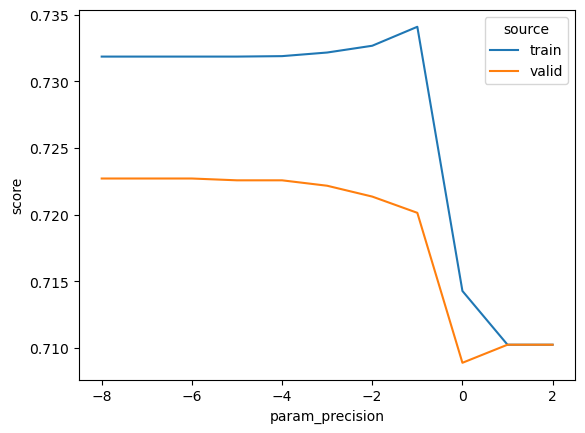

In [11]:
#### BASELINE MODEL ####
from sklearn.model_selection import train_test_split

all_x = df2[df2.columns[4:]].values
all_y = df2['classPriceChange'].values
#df_input.head()

print("BASELINE MODEL: RANDOM SPLIT")

print(all_x.shape)

train_x, test_x, train_y, test_y = train_test_split(
    all_x, all_y, test_size=0.30, random_state=42)


myPipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lda',LinearDiscriminantAnalysis()),
    ('gnb', GaussianNB())])

parameter_grid = {
    #'pca__n_components':[1,3,5,7,9,11],
    'gnb__var_smoothing':np.logspace(-8,2,11)
}

clf = GridSearchCV(myPipeline,
                   parameter_grid,
                   cv=5,
                   return_train_score=True)
clf.fit(train_x,train_y)

param_precision = [np.log10(x) for x in clf.cv_results_['param_gnb__var_smoothing'].data]

df_cvtrain = pd.DataFrame(
    {'source':'train',
     'param_precision':param_precision,
     'score':clf.cv_results_['mean_train_score']})

df_cvvalid = pd.DataFrame(
    {'source':'valid',
     'param_precision':param_precision,
     'score':clf.cv_results_['mean_test_score']})

df_cv = pd.concat([df_cvtrain,df_cvvalid])

sns.lineplot(data=df_cv, x="param_precision",y='score',hue="source")

print("Best Parameter Selected:\t:",clf.best_params_)

# Get optimal Threshold
thresholds = np.arange(.01,.99,.01)
train_yhatprob = clf.best_estimator_.predict_proba(train_x)[:, 1]
thresh_scores = list(map(
    lambda x: accuracy_score(train_y,train_yhatprob>x),thresholds))
best_score = thresh_scores[np.argmax(thresh_scores)]
threshold = thresholds[thresh_scores == best_score][0]
print("Optimal Train Threshold:\t",threshold)

#threshold =.5

test_yhat = (clf.best_estimator_.predict_proba(test_x)[:, 1] > threshold).astype('float')

print("Holdout Confusion Matrix")
print(confusion_matrix(test_y,test_yhat))

print("Holdout Model Accuracy:\t",accuracy_score(test_y,test_yhat))

In [12]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
all_x = df2[df2.columns[4:]].values
all_y = df2['classPriceChange'].values

# (1981 - 2024), (2024 - NOW) ::: TRAIN ACC : .576, TEST ACC: .444
# (2010 - 2024), (2024 - NOW) ::: TRAIN ACC : .576, TEST ACC: .444
# (2020 - 2024), (2024 - NOW) ::: TRAIN ACC : .616, TEST ACC: .469
# (2021 - 2024), (2024 - NOW) ::: TRAIN ACC : .630, TEST ACC: .456
# (2022 - 2024), (2024 - NOW) ::: TRAIN ACC : .642, TEST ACC: .518
# (2023 - 2024), (2024 - NOW) ::: TRAIN ACC : .684, TEST ACC: .407

earliest_train = '2000-01-01'
earliest_test = '2023-05-01'

train_mask = np.array(list(map(lambda x:
                             (x>=np.datetime64(earliest_train))&(x<np.datetime64(earliest_test)),
                             df2['date'].values)))
test_mask = np.array(list(map(lambda x:
                             (x>=np.datetime64(earliest_test)),df2['date'].values)))

train_x = all_x[train_mask]
train_y = all_y[train_mask]
test_x = all_x[test_mask]
test_y = all_y[test_mask]

print(train_x.shape,test_x.shape)
print(train_x.shape[0]/(train_x.shape[0]+test_x.shape[0]))

(5868, 98) (254, 98)
0.9585102907546553


BASELINE MODEL: NO LDA
Best Parameter Selected:	: {'var_smoothing': 1.0}
Optimal Train Threshold:	 0.09
Training Score:	 0.6015678254942058
0.531496062992126
Holdout Confusion Matrix
[[53 66]
 [77 58]]
Holdout Model Accuracy:	 0.43700787401574803


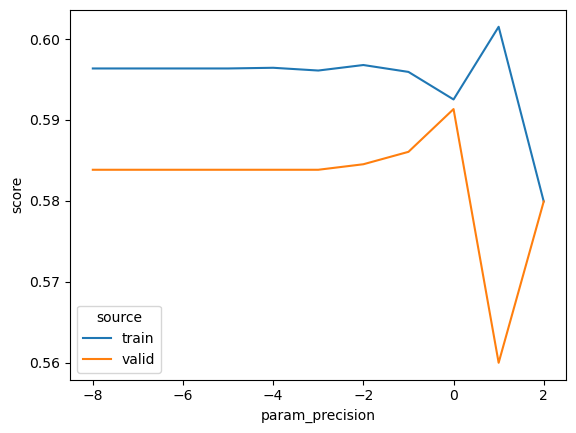

In [13]:
# BASELINE
print("BASELINE MODEL: NO LDA")

myPipeline_PRE = Pipeline([
    ('scaler', StandardScaler())
])

train_x_noLDA = myPipeline_PRE.fit_transform(train_x,train_y)
test_x_noLDA = myPipeline_PRE.fit_transform(test_x,test_y)

parameter_grid = {
    'var_smoothing':np.logspace(-8,2,11)
}

clf = GridSearchCV(GaussianNB(),
                   parameter_grid,
                   cv=5,
                   return_train_score=True)
clf.fit(train_x_noLDA,train_y)

param_precision = [np.log10(x) for x in clf.cv_results_['param_var_smoothing'].data]

df_cvtrain = pd.DataFrame(
    {'source':'train',
     'param_precision':param_precision,
     'score':clf.cv_results_['mean_train_score']})

df_cvvalid = pd.DataFrame(
    {'source':'valid',
     'param_precision':param_precision,
     'score':clf.cv_results_['mean_test_score']})

df_cv = pd.concat([df_cvtrain,df_cvvalid])

sns.lineplot(data=df_cv, x="param_precision",y='score',hue="source")

print("Best Parameter Selected:\t:",clf.best_params_)

# Get optimal Threshold
thresholds = np.arange(.01,.99,.01)
train_yhatprob = clf.best_estimator_.predict_proba(train_x_noLDA)[:, 1]
thresh_scores = list(map(
    lambda x: accuracy_score(train_y,train_yhatprob>x),thresholds))
best_score = thresh_scores[np.argmax(thresh_scores)]
threshold = thresholds[thresh_scores == best_score][0]
print("Optimal Train Threshold:\t",threshold)
print("Training Score:\t",best_score)

#threshold =.5

test_yhat_B1 = (clf.best_estimator_.predict_proba(test_x_noLDA)[:, 1] > threshold).astype('float')

print(np.mean(test_y))
print("Holdout Confusion Matrix")
print(confusion_matrix(test_y,test_yhat_B1))

print("Holdout Model Accuracy:\t",accuracy_score(test_y,test_yhat_B1))

In [14]:
GNB_noDR_log_joint_proba_train = clf.best_estimator_.predict_joint_log_proba(train_x)
GNB_noDR_log_joint_proba_valid = clf.best_estimator_.predict_joint_log_proba(test_x)

BASELINE MODEL: DEFINED SPLIT
Best Parameter Selected:	: {'gnb__var_smoothing': 10.0}
Optimal Train Threshold:	 0.43
Training Score:	 0.6167348329925018
0.531496062992126
Holdout Confusion Matrix
[[ 16 103]
 [ 17 118]]
Holdout Model Accuracy:	 0.5275590551181102


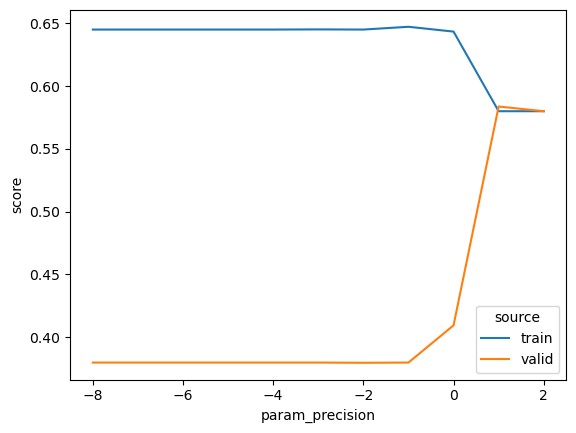

In [15]:
# BASELINE
print("BASELINE MODEL: DEFINED SPLIT")

myPipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('lda',LinearDiscriminantAnalysis()),
        ('gnb',GaussianNB())])
    
parameter_grid = {
    #'pca__n_components':[1,3,5,7,9,11],
    'gnb__var_smoothing':np.logspace(-8,2,11)
}

clf = GridSearchCV(myPipeline,
                   parameter_grid,
                   cv=5,
                   return_train_score=True)
clf.fit(train_x,train_y)

param_precision = [np.log10(x) for x in clf.cv_results_['param_gnb__var_smoothing'].data]

df_cvtrain = pd.DataFrame(
    {'source':'train',
     'param_precision':param_precision,
     'score':clf.cv_results_['mean_train_score']})

df_cvvalid = pd.DataFrame(
    {'source':'valid',
     'param_precision':param_precision,
     'score':clf.cv_results_['mean_test_score']})

df_cv = pd.concat([df_cvtrain,df_cvvalid])

sns.lineplot(data=df_cv, x="param_precision",y='score',hue="source")

print("Best Parameter Selected:\t:",clf.best_params_)

# Get optimal Threshold
thresholds = np.arange(.01,.99,.01)
train_yhatprob = clf.best_estimator_.predict_proba(train_x)[:, 1]
thresh_scores = list(map(
    lambda x: accuracy_score(train_y,train_yhatprob>x),thresholds))
best_score = thresh_scores[np.argmax(thresh_scores)]
threshold = thresholds[thresh_scores == best_score][0]
print("Optimal Train Threshold:\t",threshold)
print("Training Score:\t",best_score)

#threshold =.5
test_yhat_B2 = (clf.best_estimator_.predict_proba(test_x)[:, 1] > threshold).astype('float')

print(np.mean(test_y))
print("Holdout Confusion Matrix")
print(confusion_matrix(test_y,test_yhat_B2))

print("Holdout Model Accuracy:\t",accuracy_score(test_y,test_yhat_B2))

In [16]:
myPipeline_PRE = Pipeline([
        ('scaler', StandardScaler()),
        ('lda',LinearDiscriminantAnalysis())])
train_x_LDA = myPipeline_PRE.fit_transform(train_x,train_y)

GNB_DR_log_joint_proba_train = clf.best_estimator_['gnb'].predict_joint_log_proba(train_x_LDA)


gnb_train_try = clf.best_estimator_['gnb'].predict_log_proba(train_x_LDA)

print(GNB_DR_log_joint_proba_train[0],gnb_train_try[0]+np.log(np.mean(train_y)))


[-2.71647771 -3.04622486] [-1.40912617 -1.73887332]


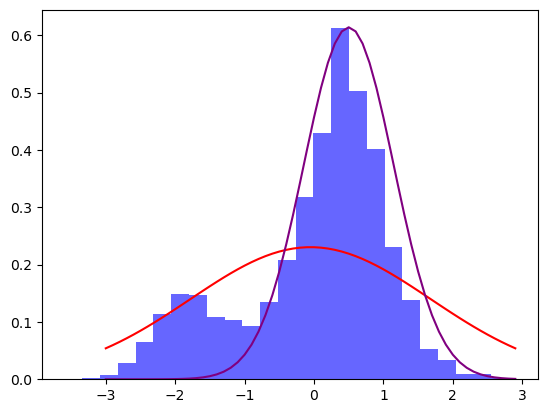

In [17]:
# Checking assumptions. Is the separating hyperplane of the LDA output normal?
myPipeline_Check = Pipeline([
    ('scaler', StandardScaler()),
    ('lda',LinearDiscriminantAnalysis())])
X_DL = myPipeline_Check.fit_transform(train_x,train_y)

# Plotting the histogram. 
plt.hist(X_DL, bins=25, density=True, alpha=0.6, color='b')

x_axis = np.arange(-3, 3, 0.1)
# Calculating mean and standard 
# deviation
mean = np.mean(x_axis)
sd = np.std(x_axis)
plt.plot(x_axis, scipy.stats.norm.pdf(x_axis, mean, sd),color='r',label="Z(0,1)")


mean = .5
sd = .65
plt.plot(x_axis, scipy.stats.norm.pdf(x_axis, mean, sd),color='purple',label="Z(.5,.6)")

plt.show()

Smallest N with at least 95% variance retained:	 22


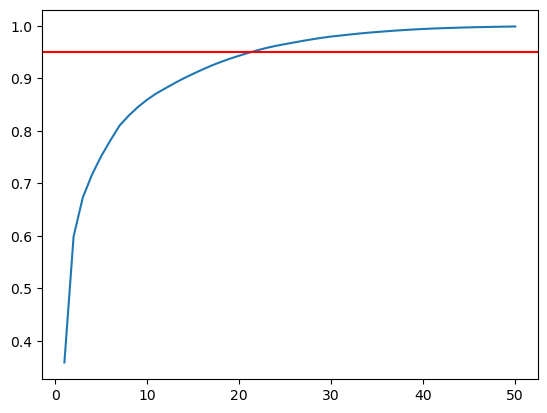

In [18]:
n_options = [x+1 for x in range(50)]
scores = []
for n in n_options:
    myPipeline_PRE = Pipeline([
        ('scaler', StandardScaler()),
        ('pca',PCA(n_components=n))
        ])
    myPipeline_PRE.fit(train_x)
    scores.append(np.sum(myPipeline_PRE['pca'].explained_variance_ratio_))

best_n = n_options[np.argmax([x>=.95 for x in scores])]

print("Smallest N with at least 95% variance retained:\t",best_n)
plt.plot(n_options,scores)
plt.axhline(y = 0.95, color = 'r', linestyle = '-') 

In [19]:
# Preprocessing

myPipeline_PRE = Pipeline([
    ('scaler', StandardScaler()),
    ('pca',PCA(n_components=best_n))])

train_xD = myPipeline_PRE.fit_transform(train_x)
test_xD = myPipeline_PRE.fit_transform(test_x)

train_xD_1 = train_xD[train_y==1]
train_xD_0 = train_xD[train_y==0]

print("Train Data, y==1:\t",train_xD_1.shape)
print("Train Data, y==0:\t",train_xD_0.shape)

Train Data, y==1:	 (2465, 22)
Train Data, y==0:	 (3403, 22)


In [38]:
print(np.max(train_xD[:,0]))

18.783714219547182


9.299536827944052e-16 5.92929061959777
-8.21933447780089 18.783714219547182
-1.549922804657342e-16 4.851173109583805
-11.141570331720256 17.659934371123274
3.148280696960226e-16 2.694830928537465
-9.06986646489902 17.013723172629085
-4.649768413972026e-16 2.064654340362827
-3.6523224306989324 14.228350166840682
2.373319294631555e-16 1.8599980655681947
-7.302161416319551 12.103429345249927
2.324884206986013e-16 1.716494812427201
-7.520316232080954 7.944347293838387
6.780912270375871e-17 1.6662995039271644
-8.940679182291177 23.765020310086705
-5.618470166882865e-16 1.3643100464240452
-8.102859172932988 9.86882752050369
-2.421754382277097e-16 1.2656306641368078
-6.364902669433574 7.654783551966198
-5.279424553364071e-16 1.1690103665871283
-7.689157277713677 8.864355234528581
7.095740340071893e-16 1.0821234257230152
-4.74964910516455 17.941625692756887
9.263210512209895e-17 0.9858592417456409
-1.8719360656331965 6.545124272400492
-2.470189469922639e-16 0.9796334805553177
-4.87585686979865

IndexError: index 22 is out of bounds for axis 1 with size 22

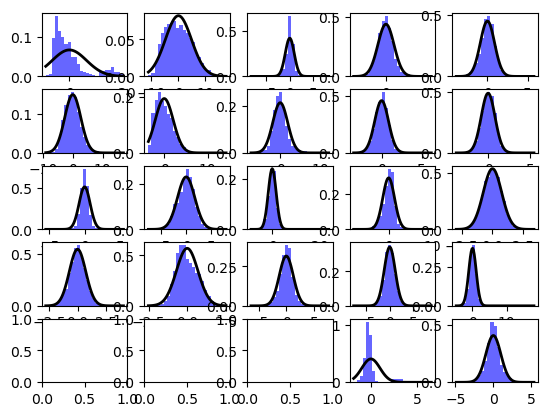

In [48]:
fig, axs = plt.subplots(5,5)

X_C = train_xD[:,0]
axs[0,0].hist(X_C,bins=25, density=True, alpha=0.6, color='b')
#  Plot the PDF.
mu, std = scipy.stats.norm.fit(X_C)
xmin = np.min(X_C)
xmax = np.max(X_C)
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu, std)
axs[0,0].plot(x, p, 'k', linewidth=2)
# title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
# plt.title(title)
print(mu, std)
print(xmin,xmax)
# plt.show()

X_C = train_xD[:,1]
axs[0,1].hist(X_C,bins=25, density=True, alpha=0.6, color='b')
#  Plot the PDF.
mu, std = scipy.stats.norm.fit(X_C)
xmin = np.min(X_C)
xmax = np.max(X_C)
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu, std)
axs[0,1].plot(x, p, 'k', linewidth=2)
# title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
# plt.title(title)
print(mu, std)
print(xmin,xmax)
# plt.show()

X_C = train_xD[:,2]
axs[1,0].hist(X_C,bins=25, density=True, alpha=0.6, color='b')
#  Plot the PDF.
mu, std = scipy.stats.norm.fit(X_C)
xmin = np.min(X_C)
xmax = np.max(X_C)
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu, std)
axs[1,0].plot(x, p, 'k', linewidth=2)
# title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
# plt.title(title)
print(mu, std)
print(xmin,xmax)
# plt.show()

X_C = train_xD[:,3]
axs[1,1].hist(X_C,bins=25, density=True, alpha=0.6, color='b')
#  Plot the PDF.
mu, std = scipy.stats.norm.fit(X_C)
xmin = np.min(X_C)
xmax = np.max(X_C)
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu, std)
axs[1,1].plot(x, p, 'k', linewidth=2)
# title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
# plt.title(title)
print(mu, std)
print(xmin,xmax)
# plt.show()

X_C = train_xD[:,4]
axs[1,2].hist(X_C,bins=25, density=True, alpha=0.6, color='b')
#  Plot the PDF.
mu, std = scipy.stats.norm.fit(X_C)
xmin = np.min(X_C)
xmax = np.max(X_C)
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu, std)
axs[1,2].plot(x, p, 'k', linewidth=2)
# title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
# plt.title(title)
print(mu, std)
print(xmin,xmax)
# plt.show()

X_C = train_xD[:,5]
axs[2,1].hist(X_C,bins=25, density=True, alpha=0.6, color='b')
#  Plot the PDF.
mu, std = scipy.stats.norm.fit(X_C)
xmin = np.min(X_C)
xmax = np.max(X_C)
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu, std)
axs[2,1].plot(x, p, 'k', linewidth=2)
# title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
# plt.title(title)
print(mu, std)
print(xmin,xmax)
# plt.show()

X_C = train_xD[:,6]
axs[2,2].hist(X_C,bins=25, density=True, alpha=0.6, color='b')
#  Plot the PDF.
mu, std = scipy.stats.norm.fit(X_C)
xmin = np.min(X_C)
xmax = np.max(X_C)
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu, std)
axs[2,2].plot(x, p, 'k', linewidth=2)
# title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
# plt.title(title)
print(mu, std)
print(xmin,xmax)
# plt.show()

X_C = train_xD[:,7]
axs[2,3].hist(X_C,bins=25, density=True, alpha=0.6, color='b')
#  Plot the PDF.
mu, std = scipy.stats.norm.fit(X_C)
xmin = np.min(X_C)
xmax = np.max(X_C)
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu, std)
axs[2,3].plot(x, p, 'k', linewidth=2)
# title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
# plt.title(title)
print(mu, std)
print(xmin,xmax)
# plt.show()


X_C = train_xD[:,8]
axs[3,2].hist(X_C,bins=25, density=True, alpha=0.6, color='b')
#  Plot the PDF.
mu, std = scipy.stats.norm.fit(X_C)
xmin = np.min(X_C)
xmax = np.max(X_C)
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu, std)
axs[3,2].plot(x, p, 'k', linewidth=2)
# title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
# plt.title(title)
print(mu, std)
print(xmin,xmax)
# plt.show()


X_C = train_xD[:,9]
axs[3,3].hist(X_C,bins=25, density=True, alpha=0.6, color='b')
#  Plot the PDF.
mu, std = scipy.stats.norm.fit(X_C)
xmin = np.min(X_C)
xmax = np.max(X_C)
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu, std)
axs[3,3].plot(x, p, 'k', linewidth=2)
# title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
# plt.title(title)
print(mu, std)
print(xmin,xmax)
# plt.show()

X_C = train_xD[:,10]
axs[3,4].hist(X_C,bins=25, density=True, alpha=0.6, color='b')
#  Plot the PDF.
mu, std = scipy.stats.norm.fit(X_C)
xmin = np.min(X_C)
xmax = np.max(X_C)
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu, std)
axs[3,4].plot(x, p, 'k', linewidth=2)
# title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
# plt.title(title)
print(mu, std)
print(xmin,xmax)
# plt.show()

X_C = train_xD[:,11]
axs[4,3].hist(X_C,bins=25, density=True, alpha=0.6, color='b')
#  Plot the PDF.
mu, std = scipy.stats.norm.fit(X_C)
xmin = np.min(X_C)
xmax = np.max(X_C)
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu, std)
axs[4,3].plot(x, p, 'k', linewidth=2)
# title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
# plt.title(title)
print(mu, std)
print(xmin,xmax)
# plt.show()

X_C = train_xD[:,12]
axs[4,4].hist(X_C,bins=25, density=True, alpha=0.6, color='b')
#  Plot the PDF.
mu, std = scipy.stats.norm.fit(X_C)
xmin = np.min(X_C)
xmax = np.max(X_C)
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu, std)
axs[4,4].plot(x, p, 'k', linewidth=2)
# title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
# plt.title(title)
print(mu, std)
print(xmin,xmax)
# plt.show()

X_C = train_xD[:,13]
axs[0,2].hist(X_C,bins=25, density=True, alpha=0.6, color='b')
#  Plot the PDF.
mu, std = scipy.stats.norm.fit(X_C)
xmin = np.min(X_C)
xmax = np.max(X_C)
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu, std)
axs[0,2].plot(x, p, 'k', linewidth=2)
# title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
# plt.title(title)
print(mu, std)
print(xmin,xmax)
# plt.show()

X_C = train_xD[:,14]
axs[0,3].hist(X_C,bins=25, density=True, alpha=0.6, color='b')
#  Plot the PDF.
mu, std = scipy.stats.norm.fit(X_C)
xmin = np.min(X_C)
xmax = np.max(X_C)
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu, std)
axs[0,3].plot(x, p, 'k', linewidth=2)
# title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
# plt.title(title)
print(mu, std)
print(xmin,xmax)
# plt.show()

X_C = train_xD[:,15]
axs[0,4].hist(X_C,bins=25, density=True, alpha=0.6, color='b')
#  Plot the PDF.
mu, std = scipy.stats.norm.fit(X_C)
xmin = np.min(X_C)
xmax = np.max(X_C)
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu, std)
axs[0,4].plot(x, p, 'k', linewidth=2)
# title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
# plt.title(title)
print(mu, std)
print(xmin,xmax)
# plt.show()


X_C = train_xD[:,16]
axs[1,3].hist(X_C,bins=25, density=True, alpha=0.6, color='b')
#  Plot the PDF.
mu, std = scipy.stats.norm.fit(X_C)
xmin = np.min(X_C)
xmax = np.max(X_C)
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu, std)
axs[1,3].plot(x, p, 'k', linewidth=2)
# title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
# plt.title(title)
print(mu, std)
print(xmin,xmax)
# plt.show()

X_C = train_xD[:,17]
axs[1,4].hist(X_C,bins=25, density=True, alpha=0.6, color='b')
#  Plot the PDF.
mu, std = scipy.stats.norm.fit(X_C)
xmin = np.min(X_C)
xmax = np.max(X_C)
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu, std)
axs[1,4].plot(x, p, 'k', linewidth=2)
# title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
# plt.title(title)
print(mu, std)
print(xmin,xmax)
# plt.show()

X_C = train_xD[:,18]
axs[2,0].hist(X_C,bins=25, density=True, alpha=0.6, color='b')
#  Plot the PDF.
mu, std = scipy.stats.norm.fit(X_C)
xmin = np.min(X_C)
xmax = np.max(X_C)
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu, std)
axs[2,0].plot(x, p, 'k', linewidth=2)
# title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
# plt.title(title)
print(mu, std)
print(xmin,xmax)
# plt.show()

X_C = train_xD[:,19]
axs[2,4].hist(X_C,bins=25, density=True, alpha=0.6, color='b')
#  Plot the PDF.
mu, std = scipy.stats.norm.fit(X_C)
xmin = np.min(X_C)
xmax = np.max(X_C)
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu, std)
axs[2,4].plot(x, p, 'k', linewidth=2)
# title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
# plt.title(title)
print(mu, std)
print(xmin,xmax)
# plt.show()

X_C = train_xD[:,20]
axs[3,0].hist(X_C,bins=25, density=True, alpha=0.6, color='b')
#  Plot the PDF.
mu, std = scipy.stats.norm.fit(X_C)
xmin = np.min(X_C)
xmax = np.max(X_C)
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu, std)
axs[3,0].plot(x, p, 'k', linewidth=2)
# title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
# plt.title(title)
print(mu, std)
print(xmin,xmax)
# plt.show()

X_C = train_xD[:,21]
axs[3,1].hist(X_C,bins=25, density=True, alpha=0.6, color='b')
#  Plot the PDF.
mu, std = scipy.stats.norm.fit(X_C)
xmin = np.min(X_C)
xmax = np.max(X_C)
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu, std)
axs[3,1].plot(x, p, 'k', linewidth=2)
# title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
# plt.title(title)
print(mu, std)
print(xmin,xmax)
# plt.show()

# X_C = train_xD[:,22]
# axs[4,0].hist(X_C,bins=25, density=True, alpha=0.6, color='b')
# #  Plot the PDF.
# mu, std = scipy.stats.norm.fit(X_C)
# xmin = np.min(X_C)
# xmax = np.max(X_C)
# x = np.linspace(xmin, xmax, 100)
# p = scipy.stats.norm.pdf(x, mu, std)
# axs[4,0].plot(x, p, 'k', linewidth=2)
# # title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
# # plt.title(title)
# print(mu, std)
# print(xmin,xmax)
# # plt.show()

0.0
1.0


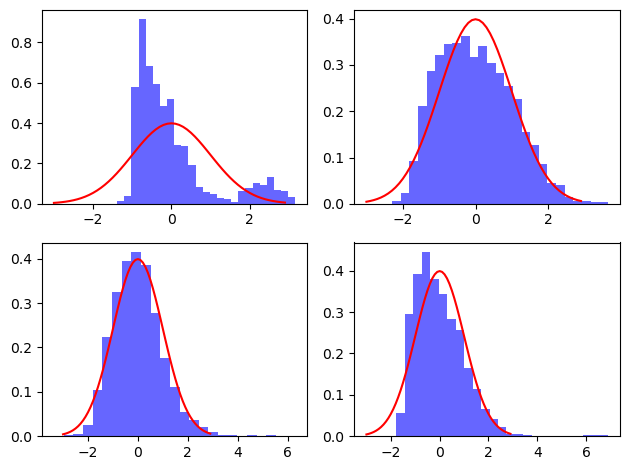

In [24]:
# Checking assumptions. How normal are the PCA components?
fig, axs = plt.subplots(2,2)

X_C = train_xD[:,0]
Xs_C = (X_C - np.mean(X_C))/np.std(X_C)
# Plotting the histogram.
axs[0,0].hist(Xs_C, bins=25, density=True, alpha=0.6, color='b')
x_axis = np.arange(-3, 3, 0.1)
mean = np.mean(Xs_C)
print(mean)
sd = np.std(Xs_C)
print(sd)
axs[0,0].plot(x_axis, scipy.stats.norm.pdf(x_axis, mean, sd),color='r')

X_C = train_xD[:,1]
Xs_C = (X_C - np.mean(X_C))/np.std(X_C)
# Plotting the histogram.
axs[0,1].hist(Xs_C, bins=25, density=True, alpha=0.6, color='b')
x_axis = np.arange(-3, 3, 0.1)
mean = 0
sd = 1
axs[0,1].plot(x_axis, scipy.stats.norm.pdf(x_axis, mean, sd),color='r')

X_C = train_xD[:,2]
Xs_C = (X_C - np.mean(X_C))/np.std(X_C)
# Plotting the histogram.
axs[1,0].hist(Xs_C, bins=25, density=True, alpha=0.6, color='b')
x_axis = np.arange(-3, 3, 0.1)
mean = 0
sd = 1
axs[1,0].plot(x_axis, scipy.stats.norm.pdf(x_axis, mean, sd),color='r')

X_C = train_xD[:,3]
Xs_C = (X_C - np.mean(X_C))/np.std(X_C)
# Plotting the histogram.
axs[1,1].hist(Xs_C, bins=25, density=True, alpha=0.6, color='b')
x_axis = np.arange(-3, 3, 0.1)
mean = 0
sd = 1
axs[1,1].plot(x_axis, scipy.stats.norm.pdf(x_axis, mean, sd),color='r')

plt.tight_layout()

In [161]:
myPipeline_MIX = Pipeline([
    ('mix', GaussianMixture())])

parameter_grid_MIX = {
    'mix__n_components':[x for x in range(1,20)],
    'mix__random_state':[101,202,303,404]
}

Best Parameter Selected:	: {'mix__n_components': 1, 'mix__random_state': 101}


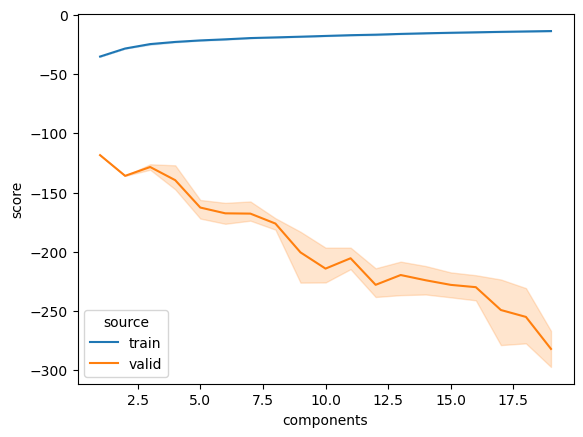

In [162]:
clf_M1 = GridSearchCV(myPipeline_MIX,
                   parameter_grid_MIX,
                   cv = 5,
                   return_train_score=True)
clf_M1.fit(train_xD_1)

param_comp = clf_M1.cv_results_['param_mix__n_components']
param_rs = clf_M1.cv_results_['param_mix__random_state']

df_cvtrain = pd.DataFrame(
    {'source':'train',
     'components':param_comp,
     'random_state':param_rs,
     'score':clf_M1.cv_results_['mean_train_score']})

df_cvvalid = pd.DataFrame(
    {'source':'valid',
     'components':param_comp,
     'random_state':param_rs,
     'score':clf_M1.cv_results_['mean_test_score']})

df_cv = pd.concat([df_cvtrain,df_cvvalid])

sns.lineplot(data=df_cv, x="components",y='score',hue="source")
print("Best Parameter Selected:\t:",clf_M1.best_params_)

Best Parameter Selected:	: {'mix__n_components': 3, 'mix__random_state': 202}


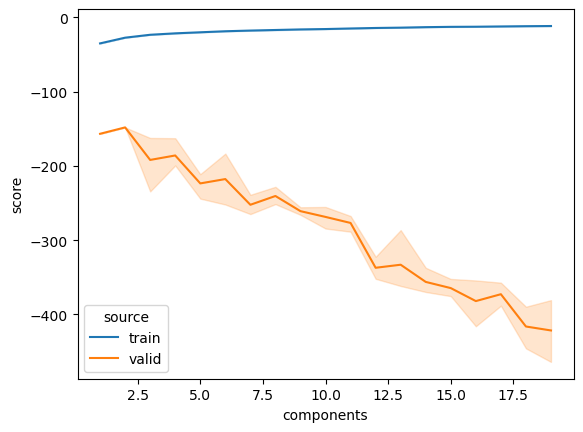

In [163]:
clf_M0 = GridSearchCV(myPipeline_MIX,
                   parameter_grid_MIX,
                   cv = 5,
                   return_train_score=True)
clf_M0.fit(train_xD_0)

param_comp = clf_M0.cv_results_['param_mix__n_components']
param_rs = clf_M0.cv_results_['param_mix__random_state']

df_cvtrain = pd.DataFrame(
    {'source':'train',
     'components':param_comp,
     'random_state':param_rs,
     'score':clf_M0.cv_results_['mean_train_score']})

df_cvvalid = pd.DataFrame(
    {'source':'valid',
     'components':param_comp,
     'random_state':param_rs,
     'score':clf_M0.cv_results_['mean_test_score']})

df_cv = pd.concat([df_cvtrain,df_cvvalid])

sns.lineplot(data=df_cv, x="components",y='score',hue="source")
print("Best Parameter Selected:\t:",clf_M0.best_params_)

In [164]:
pi0 = clf_M0.best_estimator_['mix'].weights_
mu0 = clf_M0.best_estimator_['mix'].means_
cov0 = clf_M0.best_estimator_['mix'].covariances_
pi1 = clf_M1.best_estimator_['mix'].weights_
mu1 = clf_M1.best_estimator_['mix'].means_
cov1 = clf_M1.best_estimator_['mix'].covariances_
p1 = np.mean(train_y)

param_tuple = (p1,pi0,pi1,mu0,mu1,cov0,cov1)

In [165]:
# P(X,Y=1) = P(Y=1) P(X|Y=1) / P(X)
#          = P(Y=1) SUM P(Z)P(X|Z,Y=1) / P(X)
#          = P(Y=1) SUM P(Z)P(X|Z,Y=1) / ( P(Y=1) P(X|Y=1) + P(Y=0) P(X|Y=0))
#          = P(Y=1) SUM P(Z)P(X|Z,Y=1) / ( P(Y=1) SUM P(Z) P(X|Z,Y=1) + P(Y=0) SUM P(Z) P(X|Z,Y=0))

#x_D = train_xD_0[0]
#x_D = train_xD_1[0]

def prob_gmm_joint_xy(x_D, param_tuple):
    p1, pi0, pi1, mu0, mu1, cov0, cov1 = param_tuple
    
    K0 = pi0.shape[0]
    K1 = pi1.shape[0]
    
    pdf_z0 = np.array(list(map(
                        lambda k: scipy.stats.multivariate_normal.pdf(x_D,mu0[k],cov0[k]),
                        range(K0)
    )))
    num_z0 = (1-p1)*np.sum(pi0*pdf_z0)
    
    pdf_z1 = np.array(list(map(
                        lambda k: scipy.stats.multivariate_normal.pdf(x_D,mu1[k],cov1[k]),
                        range(K1)
    )))
    num_z1 = p1*np.sum(pi1*pdf_z1)
    
    #p_x = num_z0+num_z1
    
    return [num_z0,num_z1]

# Probability of data belonging to each class
train1_y_proba = np.array(list(map(lambda x: prob_gmm_joint_xy(x,param_tuple), train_xD_1)))
# Assignment of data to each class
train1_yhat =list(map(lambda x: 1*(x[1]>x[0]),train1_y_proba))

# Probability of data belonging to each class
train0_y_proba = np.array(list(map(lambda x: prob_gmm_joint_xy(x,param_tuple), train_xD_0)))
# Assignment of data to each class
train0_yhat =list(map(lambda x: 1*(x[1]>x[0]),train0_y_proba))

test_y_proba = np.array(list(map(lambda x: prob_gmm_joint_xy(x,param_tuple), test_xD)))
test_yhat =list(map(lambda x: 1*(x[1]>x[0]),test_y_proba))

In [166]:
print("Percent of Training Data labeled 0 predicted as 0:\t%s" % round(1-np.mean(train0_yhat),3))
print("Percent of Training Data labeled 0 predicted as 1:\t%s" % round(np.mean(train0_yhat),3))
print("Percent of Training Data labeled 1 predicted as 0:\t%s" % round(1-np.mean(train1_yhat),3))
print("Percent of Training Data labeled 1 predicted as 1:\t%s" % round(np.mean(train1_yhat),3))

Percent of Training Data labeled 0 predicted as 0:	0.948
Percent of Training Data labeled 0 predicted as 1:	0.052
Percent of Training Data labeled 1 predicted as 0:	0.908
Percent of Training Data labeled 1 predicted as 1:	0.092


In [ ]:
#
GMM_DR_log_joint_proba_train = np.array(list(map(lambda x: np.log(prob_gmm_joint_xy(x,param_tuple)), train_xD)))
GMM_DR_log_joint_proba_valid = np.array(list(map(lambda x: np.log(prob_gmm_joint_xy(x,param_tuple)), test_xD)))
#GNB_DR_log_joint_proba_train = clf.best_estimator_.predict_joint_log_proba(train_x_LDA)
#GNB_DR_log_joint_proba_valid = clf.best_estimator_.predict_joint_log_proba(test_x_LDA)

In [ ]:
print(GMM_DR_log_joint_proba_train[0],
      GNB_DR_log_joint_proba_train[0])

print(GMM_DR_log_joint_proba_train[0],
      GNB_DR_log_joint_proba_train[0])

In [ ]:
GNB_noDR_log_joint_proba_valid = clf.best_estimator_.predict_joint_log_proba(test_x_LDA)

In [ ]:
N0 = len(train0_yhat)
N1 = len(train1_yhat)
train_yhat_ct = np.concatenate([train0_yhat,train1_yhat])
train_y_ct = np.concatenate([np.zeros(N0),np.ones(N1)])

print(confusion_matrix(train_y_ct,train_yhat_ct))
print(accuracy_score(train_y_ct,train_yhat_ct))

In [ ]:
print(confusion_matrix(test_y,test_yhat))
print(accuracy_score(test_y,test_yhat))

In [ ]:
# Given a date range, how can we test on it?

earliest_train = '2016-01-01'
earliest_test = '2022-01-01'

train_base_score = 0.541
test_base_score = 0.5378
train_upgrade_score = 0.5936
test_upgrade_score = 0.53608

In [ ]:
# (1980 - 2024), (2024 - NOW) ::: TRAIN ACC : .708, TEST ACC: .568
# (2000 - 2024), (2024 - NOW) ::: TRAIN ACC : .446, TEST ACC: .555 (ALL 0)
# (2010 - 2024), (2024 - NOW) ::: TRAIN ACC : .576, TEST ACC: .444
# (2020 - 2024), (2024 - NOW) ::: TRAIN ACC : .616, TEST ACC: .469
# (2021 - 2024), (2024 - NOW) ::: TRAIN ACC : .630, TEST ACC: .456
# (2022 - 2024), (2024 - NOW) ::: TRAIN ACC : .642, TEST ACC: .518
# (2023 - 2024), (2024 - NOW) ::: TRAIN ACC : .684, TEST ACC: .407


df_date_train_test = pd.DataFrame(
    data={
        'trainStart':[1980,2000,2010,2020,2021,2022,2023],
        'testStart':[2024,2024,2024,2024,2024,2024,2024],
        'trainAcc':[.708,.446,.576,.616,.630,.642,.684],
        'testAcc':[.568,.555,.444,.469,.456,.518,.407],
    }
)

sns.scatterplot(df_date_train_test,x='trainStart',y='trainAcc')
sns.scatterplot(df_date_train_test,x='trainStart',y='testAcc')